In [292]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.odr import Model
from scipy.odr import RealData
from scipy.odr import ODR

### Importing Data for Aluminium

In [293]:
data30degH2 = np.loadtxt('Data/Silver/30degSilverDataHone2')
df30deg = data30degH2[:,0]
iv30deg = data30degH2[:,1]
ov30deg = data30degH2[:,2]

data60degH2 = np.loadtxt('Data/Silver/60degSilverDataHone2')
df60deg = data60degH2[:,0]
iv60deg= data60degH2[:,1]
ov60deg = data60degH2[:,2]

data90degH2 = np.loadtxt('Data/Silver/90degSilverDataHone2')
df90deg = data90degH2[:,0]
iv90deg= data90degH2[:,1]
ov90deg = data90degH2[:,2]

data120degH2 = np.loadtxt('Data/Silver/120degSilverDataHone2')
df120deg = data120degH2[:,0]
iv120deg= data120degH2[:,1]
ov120deg = data120degH2[:,2]

# 423.15K Graph without outliers
data150degH2 = np.loadtxt('Data/Silver/150degSilverDataHone2_copy')
df150deg = data150degH2[:,0]
iv150deg= data150degH2[:,1]
ov150deg = data150degH2[:,2]

# 423.15K Graph as a whole
dfreq = np.loadtxt('Data/Silver/150degSilverDataHone2')
driverfrequency = dfreq[:,0]
inputvoltage = dfreq[:,1]
outputvoltage = dfreq[:,2]

### Errors throughout the experiment

In [294]:
# Resolution on the DAQ's ADC:

VoltageRange = 10 # As it was specified on the computer to work in this range
BitResolution = 12 # As i was using a NI USB 6008 which only has a 12 bit ADC

Resolution = VoltageRange/2**(BitResolution)

print('This is the smallest change in voltage the ADC can measure:',Resolution)

# This is equivalent to 2.44mV 

# Must add the absolute accuracy of the NI USB as well which accounts for all of the changes or errors in measurements due to Noise and temperature drift of the device.

AbsAccuracy = 4.38 * 10 **(-3) 

OVError = Resolution + AbsAccuracy
print('This is the total error of the Output Voltage measurements including everything:',OVError)

This is the smallest change in voltage the ADC can measure: 0.00244140625
This is the total error of the Output Voltage measurements including everything: 0.00682140625


### Making lists of Errors on each of the Data sets Driver Frequencies.

In [295]:
#  Creating a list the same size as the x values as they all have the same errors

dferror = 0.75 # consistent for all measurements

df30degerr = [dferror] * len(df30deg)
df60degerr = [dferror] * len(df60deg)
df90degerr = [dferror] * len(df90deg)
df120degerr = [dferror] * len(df120deg)
df150degerr = [dferror] * len(df150deg)
df150degerr2 = [dferror] * len(driverfrequency)

In [296]:
# Overlays
# plt.title('Aluminium Rod Output Voltage vs Driver Frequency at Various Temperatures')
# plt.xlabel('Driver Frequency (Hz)')
# plt.ylabel('Output Voltage (V)')

# plt.plot(df30deg, ov30deg, '.', label = '303.15K')
# plt.plot(df60deg, ov60deg, '.', label = '333.15K')
# plt.plot(df90deg, ov90deg, '.', label='363.15K')
# plt.plot(df120deg, ov120deg, '.', label='393.15K')
# plt.plot(df150deg, ov150deg, '.', label='422.15K')

### Modelling the Data Using Orthogonal Distance Regression

In [297]:
# Modelling the data using a Lorentzian 
# Chose to pick a Lorentzian and use ODR as both of my measurements are independent for the x and y axis and have separate errors.
# Another Reason being that its peak is more sharp than a Gaussian which is what is seen with resonance. 

# A being the amplitude of the Lorentzian, w being omega the frequency and w0 being the resonant frequency,
# with deltaw being the full width at half maximum

def Lorentzian(B, w):
    A, w0, deltaw, b = B
    return (A / ((w - w0)**2 + (0.5 * deltaw)**2)) + b

Lorentzian_model = Model(Lorentzian)

# Here I am using Scipy to store the Function of the Lorentzian as a model, the Model part stores info about the function i want to fit which is the Lorentzian.

## This is the Lorentzian Function: $ \frac{A}{\left(\omega - \omega_{0}\right)^{2} + (\frac{1}{2} \Delta\omega)^{2}} + b $

In [298]:
# Creating a for loop to sweep through and gather the parameters and errors for all temperatures quickly

# Putting all of my data into a list for the x and y axis
SilverData_x_axis = [df30deg, df60deg, df90deg, df120deg, df150deg, driverfrequency]
SilverData_y_axis = [ov30deg, ov60deg, ov90deg, ov120deg, ov150deg, outputvoltage]
SilverData_errors = [df30degerr, df60degerr, df90degerr, df120degerr, df150degerr, df150degerr2]
EstimatesofFMHW = [3.5, 5, 4, 3.5, 3, 3] # Estimated using the individual plots of the data below
EstimatesofAmplitudes = [1.75, 1.1, 1.2, 0.9, 0.49, 0.49] # Estimated using the data points on the graphs.
resonantfreqs = [1.678000000000000114e+02, 1.671699999999999875e+02, 1.652700000000000102e+02, 1.646299999999999955e+02, 1.639199999999999875e+02, 1.639199999999999875e+02]
bguess = [3.752054731223530837e-03, 6.302242165546090291e-03, 3.752054731223530837e-03, 3.752054731223530837e-03, 3.752054731223530837e-03, 3.752054731223530837e-03]

# Initialising all of the lists needed for later Calculations

w_fits = []
y_fits = []
w0 = []
deltaw = []
sw0 = []
sdeltaw = []
sdeltaww0 = []

for i, j, k, q, p, m, b in zip(SilverData_x_axis, SilverData_y_axis, SilverData_errors, EstimatesofFMHW, EstimatesofAmplitudes, resonantfreqs, bguess):
    # Inputting all experimental data
    w = np.array(i) # Driver Frequencies
    y = np.array(j) # Output Voltages
    sw = np.array(k) # Consistent Fluctuation on frequency measurement
    sy = np.array(OVError) # Error on ADC in NI USB 6008

    data = RealData(w ,y, sx=sw, sy=sy) # Creating the RealData object as specified on the Scipy.ODR webpage with x, y values and their uncertainties.
    # Not including covariances here as the variables are independent.

    # Must guess initial parameters for the parameters in the vector B; A (amplitude), w0 (resonant frequency) and deltaw (Full width half maximum of graph)
    Initial_Estimate = [((p * (0.5 * q)**2)), m, q, b]

    # Instantiating the Blueprint ODR with my experimental data
    myodr = ODR(data, Lorentzian_model, beta0=Initial_Estimate)

    # Running the fit
    output = myodr.run()

    # Appending the values of w0 and deltaw for later calculations:
    w0.append(output.beta[1])

    deltaw.append(output.beta[2])

    # Appending the errors of the parameters above
    sw0.append(output.sd_beta[1])
    sdeltaw.append(output.sd_beta[2])

    #Appending the Covariance of deltaw and w0 for later calculations
    # sdeltaww0.append(output.cov_beta[1, 2])

    # Printing a summary of the fit results:
    # output.pprint()

    # Extract the optimal parameters:
    popt = output.beta # Gives optimized parameters A, w0 and deltaw
    perr = output.sd_beta # Gives the Standard deviation of the parameters (errors)

    # Creating 1000 equally spaced points on the x axis for the model just made
    w_fit = np.linspace(min(w), max(w), 1000)

    # Using the parameters from the ODR to create the theoretical model
    y_fit = Lorentzian(popt, w_fit)

    # Adding these fits to their own lists for later usage
    w_fits.append(w_fit)
    y_fits.append(y_fit)

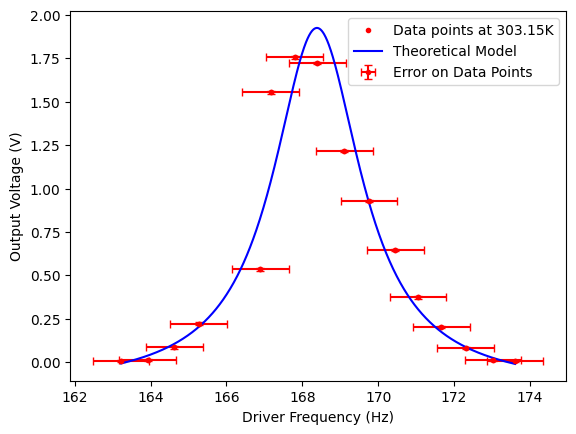

In [299]:
# Plotting the models

# Overlays
# plt.title('Theoretical Model of the resonance at 303.15K')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

# Plotting the Data as Points
plt.plot(df30deg, ov30deg, '.', label = 'Data points at 303.15K', color = 'r')
plt.errorbar(df30deg, ov30deg, xerr=df30degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(w_fits[0], y_fits[0], color = 'b', label='Theoretical Model')
# plt.errorbar(sw0, sw0)
plt.legend()
plt.savefig('303.15K-Alumini-Graph.png')

plt.show()


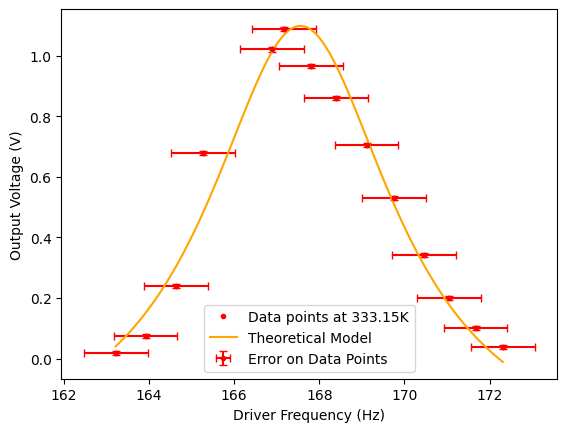

In [300]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df60deg, ov60deg, '.', label = 'Data points at 333.15K', color = 'r')
plt.errorbar(df60deg, ov60deg, xerr=df60degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[1], y_fits[1], color = 'orange', label='Theoretical Model')
plt.legend()
plt.savefig('333.15K-Alumini-Graph.png')

plt.show()

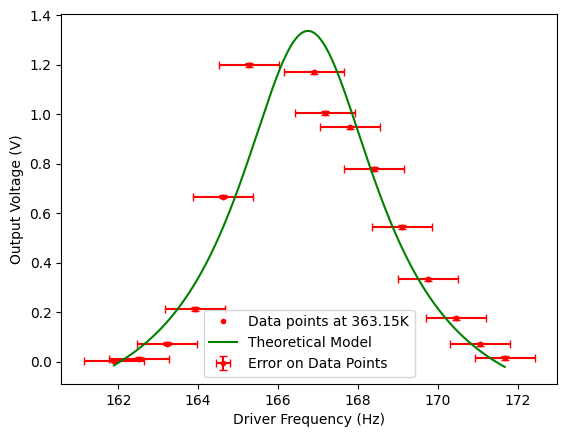

In [301]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df90deg, ov90deg, '.', label='Data points at 363.15K', color = 'r')
plt.errorbar(df90deg, ov90deg, xerr=df90degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[2], y_fits[2], color = 'g', label='Theoretical Model')
plt.legend()
plt.savefig('363.15K-Alumini-Graph.png')

plt.show()

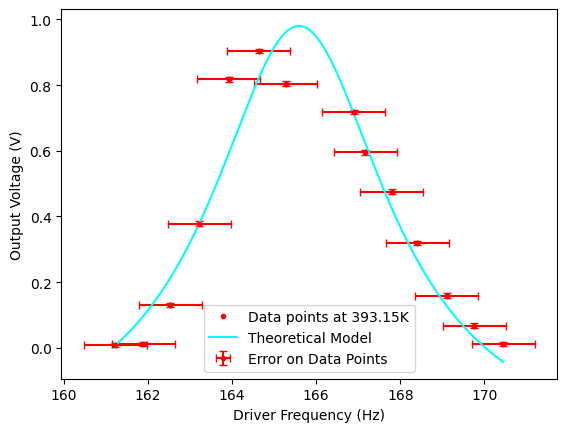

In [302]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df120deg, ov120deg, '.', label='Data points at 393.15K', color = 'r')
plt.errorbar(df120deg, ov120deg, xerr=df120degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[3], y_fits[3], color = 'cyan', label='Theoretical Model')
plt.legend()
plt.savefig('393.15K-Alumini-Graph.png')

plt.show()

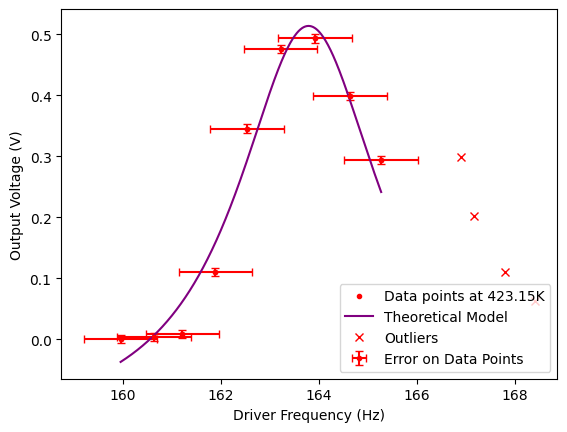

In [303]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df150deg, ov150deg, '.', label='Data points at 423.15K', color = 'r')
plt.errorbar(df150deg, ov150deg, xerr=df150degerr, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(w_fits[4], y_fits[4], color = 'purple', label='Theoretical Model')
plt.plot(1.668899999999999864e+02, 2.995737971125906896e-01, 'x', label='Outliers', color='r')
plt.plot(1.671699999999999875e+02, 2.026666746083494175e-01, 'x', color='r')
plt.plot(1.678000000000000114e+02, 1.108599269727532644e-01, 'x', color='r')
plt.plot(1.684000000000000057e+02, 6.240636572063262832e-02, 'x', color='r')
plt.legend()
plt.savefig('423.15K-Alumini-Outlierless-Graph.png')

plt.show()

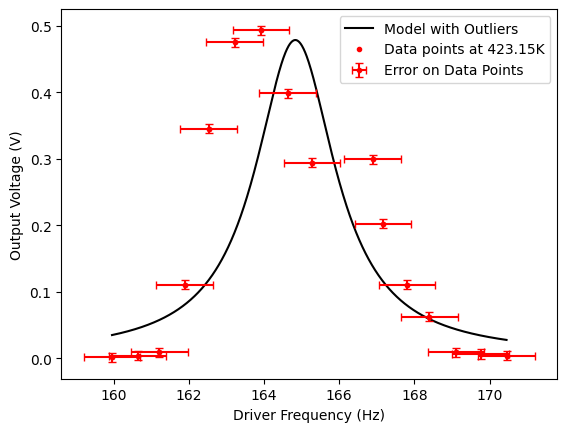

In [304]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')
# plt.plot(w_fits[4], y_fits[4], color = 'purple', label='Theoretical Model without Outliers')
plt.plot(w_fits[5], y_fits[5], color = 'black', label='Model with Outliers')
plt.errorbar(driverfrequency, outputvoltage, xerr=df150degerr2, yerr=OVError, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(driverfrequency, outputvoltage, '.', color='red', label='Data points at 423.15K')
plt.legend()
plt.savefig('423.15K-Alumini-Outliers-Graph.png')

plt.show()

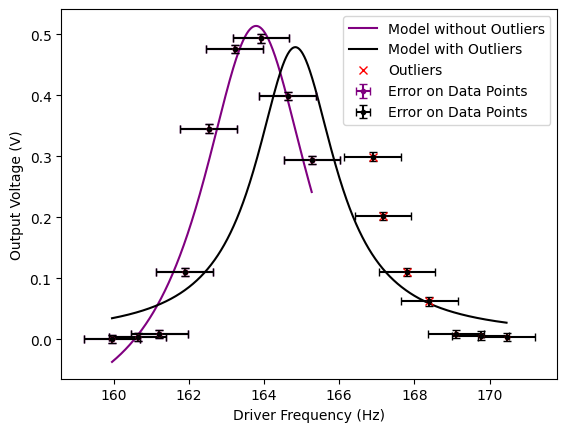

In [305]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')
plt.plot(w_fits[4], y_fits[4], color = 'purple', label='Model without Outliers')
plt.plot(w_fits[5], y_fits[5], color = 'black', label='Model with Outliers')
plt.errorbar(df150deg, ov150deg, xerr=df150degerr, yerr=OVError, fmt='.', color='purple', label='Error on Data Points', capsize=3)
plt.errorbar(driverfrequency, outputvoltage, xerr=df150degerr2, yerr=OVError, fmt='.', color='black', label='Error on Data Points', capsize=3)

plt.plot(1.668899999999999864e+02, 2.995737971125906896e-01, 'x', label='Outliers', color='r')
plt.plot(1.671699999999999875e+02, 2.026666746083494175e-01, 'x', color='r')
plt.plot(1.678000000000000114e+02, 1.108599269727532644e-01, 'x', color='r')
plt.plot(1.684000000000000057e+02, 6.240636572063262832e-02, 'x', color='r')

plt.plot(driverfrequency, outputvoltage, '.', color='red')
plt.legend()
plt.savefig('423.15K-Alumini-Overlapped-Graph.png')
plt.show()

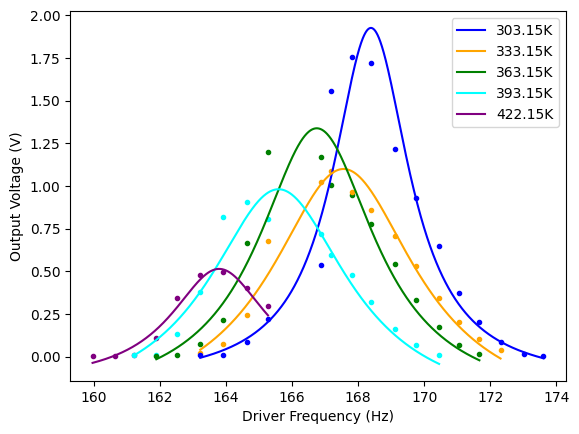

In [306]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Driver Frequency (Hz)')
plt.ylabel('Output Voltage (V)')

plt.plot(df150deg, ov150deg, '.',color = 'purple')
plt.plot(df120deg, ov120deg, '.',color = 'cyan')
plt.plot(df90deg, ov90deg, '.', color = 'g')
plt.plot(df60deg, ov60deg, '.', color = 'orange')
plt.plot(df30deg, ov30deg, '.', color = 'b')

plt.plot(w_fits[0], y_fits[0], color = 'b', label = '303.15K')
plt.plot(w_fits[1], y_fits[1], color = 'orange', label = '333.15K')
plt.plot(w_fits[2], y_fits[2], color = 'g', label='363.15K')
plt.plot(w_fits[3], y_fits[3], color = 'cyan', label='393.15K')
plt.plot(w_fits[4], y_fits[4], color = 'purple', label='422.15K')
plt.legend()
plt.savefig('Aluminium-Resonances-Graph.png')

plt.show()

### Calculating the Modulus of Rigidity and Internal Friction of the rod at Different Temperatures

In [307]:
def MORG(I, l, w0, r):
    return (2 * I * l * ((w0 * 2 * np.pi)**(2))) / (np.pi * (r ** 4))

def MomentOfInertia(m, r): # Done 
    return (1/2) * m * (r ** 2)

def MomentOfInertiaError(m, r, sm, sr): # Done 
    return np.sqrt(((0.5*r**2)**2) * (sm ** 2) + ((1.0*m*r)**2) * (sr ** 2))

def MORGError(I, l, w0, r, sI, sl, sw0, sr):
    return np.sqrt(
        (((0.636619772367581 * l * ((w0 * 2 * np.pi) ** 2)) / (r ** 4)) ** 2) * (sI ** 2) +
        (((0.636619772367581 * I * ((w0 * 2 * np.pi) ** 2)) / (r ** 4)) ** 2) * (sl ** 2) +
        ((1.27323954473516 * I * l * ((w0 * 2 * np.pi)) / (r ** 4)) ** 2) * ((sw0 * 2 * np.pi) ** 2) +
        (((-2.54647908947033 * I * l * ((w0 * 2 * np.pi) ** 2)) / (r ** 5)) ** 2) * (sr ** 2)
    )

def IFQ(deltaw, w0):
    return (np.sqrt(3) * (w0 * 2 * np.pi)) / (deltaw * 2 * np.pi) 

def IFQError(w0, deltaw, sw0, sdeltaw):
    return np.sqrt(
        (((1.73205080756888 / (deltaw * 2 * np.pi)) ** 2) * ((sw0 * 2 * np.pi) ** 2)) +
        ((-1.73205080756888 * w0 * 2 * np.pi ) / ((deltaw * 2 * np.pi) ** 2)) ** 2 * ((sdeltaw * 2 * np.pi) ** 2)
        )

In [308]:
# Defining the measured parameters and their errors for each rod to sweep through the functions:

# Taking five measurements at different points along the wire
dsilver = [2.45, 2.44, 2.46, 2.44, 2.44]
dIron = [2.48, 2.47, 2.48, 2.48, 2.48]
dbrass = [2.48, 2.47, 2.48, 2.48, 2.47]

measuredrsilver = np.mean(dsilver) / 2000 # Going from mm to m
measuredriron = np.mean(dIron) / 2000 # Going from mm to m
measuredrbrass = np.mean(dbrass) / 2000 # Going from mm to m

# Going from Aluminium, Steel to Brass

m = [(7.44/1000), (22.24/1000), (23.58/1000)]
sm = (0.005/1000)

r = [measuredrsilver, measuredriron, measuredrbrass]
sr = (0.005/1000)

l = [(353/1000), (350/1000), (353/1000)]
sl = (0.5/1000)

I_rod = [MomentOfInertia(m[0], r[0]), MomentOfInertia(m[1], r[1]), MomentOfInertia(m[2], r[2])]
sI_rod = [MomentOfInertiaError(m[0], r[0], sm, sr), MomentOfInertiaError(m[1], r[1], sm, sr), MomentOfInertiaError(m[2], r[2], sm, sr)]

I_aux = MomentOfInertia((54.54/1000), (8.70/2000))
sI_aux = MomentOfInertiaError((54.54/1000), (8.70/2000), (sm), (sr))

# Summing the errors together to get the total error.
sI = [np.sqrt((sI_rod[0] ** 2) + (sI_aux ** 2)), np.sqrt((sI_rod[1] ** 2) + (sI_aux ** 2)), np.sqrt((sI_rod[2] ** 2) + (sI_aux ** 2))]

# Creating a list of all of the moments of inertia
I = [I_rod[0] + I_aux, I_rod[1] + I_aux, I_rod[2] + I_aux]

print(f"Measured radius of silver rod: {measuredrsilver} m")
print(f"Measured radius of iron rod: {measuredriron} m")
print(f"Measured radius of brass rod: {measuredrbrass} m")
print(f"Mass of aluminium rod: {m[0]} kg, with uncertainty: {sm} kg")
print(f"Mass of steel rod: {m[1]} kg, with uncertainty: {sm} kg")
print(f"Mass of brass rod: {m[2]} kg, with uncertainty: {sm} kg")
print(f"Length of aluminium rod: {l[0]} m, with uncertainty: {sl} m")
print(f"Length of steel rod: {l[1]} m, with uncertainty: {sl} m")
print(f"Length of brass rod: {l[2]} m, with uncertainty: {sl} m")
print(f"Moment of inertia for aluminium rod: {I_rod[0]} kg·m² with uncertainty: {sI_rod[0]} kg·m²")
print(f"Moment of inertia for steel rod: {I_rod[1]} kg·m² with uncertainty: {sI_rod[1]} kg·m²")
print(f"Moment of inertia for brass rod: {I_rod[2]} kg·m² with uncertainty: {sI_rod[2]} kg·m²")
print(f"Auxiliary moment of inertia: {I_aux} kg·m² with uncertainty: {sI_aux} kg·m²")
print(f"Total moment of inertia for aluminium rod: {I[0]} kg·m² with total uncertainty: {sI[0]} kg·m²")
print(f"Total moment of inertia for steel rod: {I[1]} kg·m² with total uncertainty: {sI[1]} kg·m²")
print(f"Total moment of inertia for brass rod: {I[2]} kg·m² with total uncertainty: {sI[2]} kg·m²")


Measured radius of silver rod: 0.0012230000000000001 m
Measured radius of iron rod: 0.001239 m
Measured radius of brass rod: 0.001238 m
Mass of aluminium rod: 0.00744 kg, with uncertainty: 5e-06 kg
Mass of steel rod: 0.02224 kg, with uncertainty: 5e-06 kg
Mass of brass rod: 0.023579999999999997 kg, with uncertainty: 5e-06 kg
Length of aluminium rod: 0.353 m, with uncertainty: 0.0005 m
Length of steel rod: 0.35 m, with uncertainty: 0.0005 m
Length of brass rod: 0.353 m, with uncertainty: 0.0005 m
Moment of inertia for aluminium rod: 5.5641118800000015e-09 kg·m² with uncertainty: 4.56490104177408e-11 kg·m²
Moment of inertia for steel rod: 1.7070545520000003e-08 kg·m² with uncertainty: 1.3783024104407932e-10 kg·m²
Moment of inertia for brass rod: 1.8069872759999996e-08 kg·m² with uncertainty: 1.4601048325114227e-10 kg·m²
Auxiliary moment of inertia: 5.160165749999999e-07 kg·m² with uncertainty: 1.1871878879579519e-09 kg·m²
Total moment of inertia for aluminium rod: 5.215806868799999e-07 k

In [309]:
# Getting the values for the Modulus of rigidy for Aluminium:

G = [MORG(I[0], l[0], w0[0], r[0]), MORG(I[0], l[0], w0[1], r[0]),
     MORG(I[0], l[0], w0[2], r[0]), MORG(I[0], l[0], w0[3], r[0]),
     MORG(I[0], l[0], w0[4], r[0])]

sG = [MORGError(I[0], l[0], w0[0], r[0], sI[0], sl, sw0[0], sr), MORGError(I[0], l[0], w0[1], r[0], sI[0], sl, sw0[1], sr),
      MORGError(I[0], l[0], w0[2], r[0], sI[0], sl, sw0[2], sr), MORGError(I[0], l[0], w0[3], r[0], sI[0], sl, sw0[3], sr),
      MORGError(I[0], l[0], w0[4], r[0], sI[0], sl, sw0[4], sr)]

Q = [IFQ(deltaw[0], w0[0]), IFQ(deltaw[1], w0[1]), IFQ(deltaw[2], w0[2]),
     IFQ(deltaw[3], w0[3]), IFQ(deltaw[4], w0[4])]

sQ = [IFQError(w0[0], deltaw[0], sw0[0], sdeltaw[0]), IFQError(w0[1], deltaw[1], sw0[1], sdeltaw[1]),
      IFQError(w0[2], deltaw[2], sw0[2], sdeltaw[2]), IFQError(w0[3], deltaw[3], sw0[3], sdeltaw[3]),
      IFQError(w0[4], deltaw[4], sw0[4], sdeltaw[4])]

G = np.array(G)
print(G/1e9)
sG = np.array(sG)
print(sG/1e9)

Q = np.array(Q)
print(1/Q)
sQ = np.array(sQ)
print(1/sQ)

[58.64685296 58.07005602 57.50996352 56.71479266 55.48884891]
[0.97381013 0.96542045 0.95766206 0.94710624 0.92811246]
[0.00971032 0.01843976 0.01501322 0.01796079 0.01263015]
[0.07582764 0.10726147 0.06204881 0.05136149 0.03458027]


In [310]:
temp = np.array([303.15, 333.15, 363.15, 393.15, 423.15])
y_values = np.array(G)

# performing ODR for the above data set

# Errors on temperature in degrees
randomfluctuationsofheatbox = 1 
resolutionuncertaintyofheatbox = 0.5

#sT = np.sqrt(((1)**2) + ((0.5)**2))
sT = [np.sqrt(((1)**2) + ((0.5)**2))] * len(temp)
sT_array = np.array(sT)

sG_array = np.array(sG)

# Using ODR to plot the line of best fit:

def LinearApproximation(B, x):
    m, c = B
    return m * x + c

EstimateofSlope = (G[3] - G[2]) / (temp[3] - temp[2])

linear = Model(LinearApproximation)

mydata = RealData(G, temp, sx=sT, sy=sG)

myodr = ODR(mydata, linear, beta0=[EstimateofSlope, 2])

myoutput2 = myodr.run()

myoutput2.pprint()

slope, intercept = myoutput2.beta  # Optimal parameters
slope_error, intercept_error = myoutput2.sd_beta  # Errors in the parameters

Beta: [6.31613194e-09 2.00000000e+00]
Beta Std Error: [4.31822081e-10 0.00000000e+00]
Beta Covariance: [[5.55197762e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 3.3586286320522214e-15
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Parameter convergence


In [311]:
# Creating another ODR model to model the G trend

mydataG = RealData(temp, y_values, sx=sT_array, sy=sG_array)

EstimateofSlopeforG = (y_values[3] - y_values[2]) / (temp[3] - temp[2])

myodrG = ODR(mydataG, linear, beta0=[EstimateofSlopeforG, (6.6e10)])

myoutputG = myodrG.run()

myoutputG.pprint()

Beta: [-2.57047315e+07  6.66195370e+10]
Beta Std Error: [2.65167118e+06 9.73193962e+08]
Beta Covariance: [[ 1.00756790e+14 -3.67298494e+16]
 [-3.67298494e+16  1.35716858e+19]]
Residual Variance: 0.06978547109276828
Inverse Condition #: 0.015115377967321967
Reason(s) for Halting:
  Sum of squares convergence


In [312]:
temp_fit = np.linspace(min(temp), max(temp), 1000)
G_fit = LinearApproximation(myoutputG.beta, temp_fit)

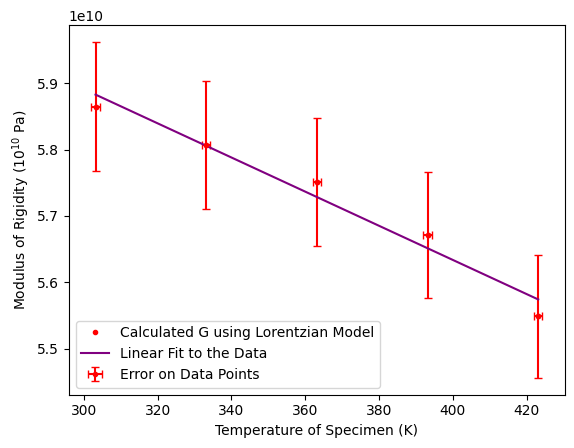

In [313]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Modulus of Rigidity ($10^{10}$ Pa)')

plt.plot(temp, G, '.', label='Calculated G using Lorentzian Model', color = 'r')
plt.errorbar(temp, G, xerr=sT, yerr=sG, fmt='.', color='r', label='Error on Data Points', capsize=3)

plt.plot(temp_fit, G_fit, color = 'purple', label='Linear Fit to the Data')

plt.legend()
plt.savefig('GvsTAlumini.png')
plt.show()

In [314]:
# Define the exponential model
def exponential_model(beta, x):
    a, b = beta  # 'beta' contains the parameters 'a' and 'b'
    return a * np.exp(b * x)

# Create the model object for ODR
Exponential = Model(exponential_model)

# Prepare the data (with errors for both temp and Q)
mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)  # temp: temperature, Q: internal friction, sT_array, sQ: uncertainties

# Set up ODR with the initial guess for parameters [a, b]
myodrQ = ODR(mydataQ, Exponential, beta0=[1, 0.01])  # beta0: initial guess 0.002 different fit

# Run the ODR regression
myoutputQ = myodrQ.run()

# Print the output
myoutputQ.pprint()

# Extract the fitted parameters and apply the model to your fit range
Q_fit2 = exponential_model(myoutputQ.beta, temp_fit)  # temp_fit: the temperature range for the fit

Beta: [ 5.21596911e+02 -5.99931986e-03]
Beta Std Error: [8.96831586e+02 5.17759709e-03]
Beta Covariance: [[ 3.40171824e+05 -1.95734188e+00]
 [-1.95734188e+00  1.13379112e-05]]
Residual Variance: 2.3644136177503396
Inverse Condition #: 4.7056737962962275e-05
Reason(s) for Halting:
  Sum of squares convergence


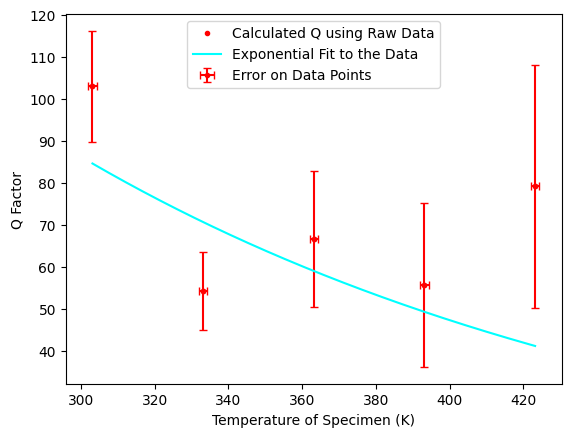

In [315]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTAlumini.png')
plt.show()

In [316]:
# Code for ODR on the data for Q

EstimateofSlope = (Q[3] - Q[2]) / (temp[3] - temp[2])

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)

myodrQ = ODR(mydataQ, linear, beta0=[EstimateofSlope, 300])

myoutputQ = myodrQ.run()

myoutputQ.pprint()

temp_fit = np.linspace(min(temp), max(temp), 1000)
Q_fit = LinearApproximation(myoutputQ.beta, temp_fit)

Beta: [ -0.27288271 161.9325789 ]
Beta Std Error: [  0.31633395 108.52745804]
Beta Covariance: [[ 3.83608288e-02 -1.31021750e+01]
 [-1.31021750e+01  4.51518597e+03]]
Residual Variance: 2.608576752177693
Inverse Condition #: 0.02851320545063037
Reason(s) for Halting:
  Sum of squares convergence


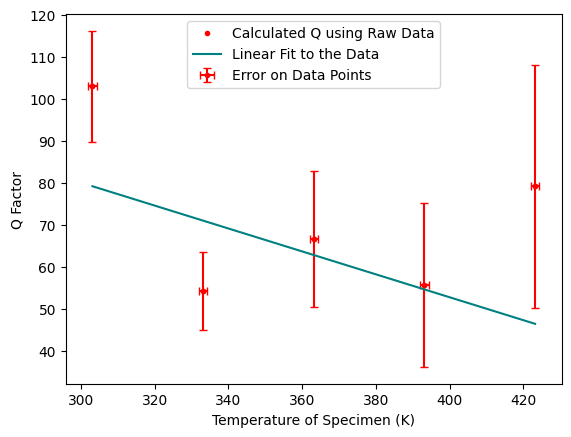

In [317]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.legend()
plt.savefig('QvsTAluminiLin.png')
plt.show()

## Calculating G and Q from the Raw Data

In [318]:
raww0Hz = [1.678000000000000114e+02, 1.671699999999999875e+02, 1.652700000000000102e+02, 1.646299999999999955e+02, 1.639199999999999875e+02]
rawdeltaw = EstimatesofFMHW # = [3, 5, 4, 3.5, 3, 3]
sw0Hz = 0.75
sdeltawraw = 0.5 # from eyeball estimates

In [319]:
def IFQError2(w0, deltaw, sw0, sdeltaw):
    return np.sqrt(
        (((0.577350269189626 / (deltaw * 2 * np.pi)) ** 2) * ((sw0 * 2 * np.pi) ** 2)) +
        ((-0.577350269189626 * w0 * 2 * np.pi ) / ((deltaw * 2 * np.pi) ** 2)) ** 2 * ((sdeltaw * 2 * np.pi) ** 2)
        )

In [320]:
G = [MORG(I[0], l[0], raww0Hz[0], r[0]), MORG(I[0], l[0], raww0Hz[1], r[0]),
     MORG(I[0], l[0], raww0Hz[2], r[0]), MORG(I[0], l[0], raww0Hz[3], r[0]),
     MORG(I[0], l[0], raww0Hz[4], r[0])]

sG = [MORGError(I[0], l[0], raww0Hz[0], r[0], sI[0], sl, sw0Hz, sr), MORGError(I[0], l[0], raww0Hz[1], r[0], sI[0], sl, sw0Hz, sr),
      MORGError(I[0], l[0], raww0Hz[2], r[0], sI[0], sl, sw0Hz, sr), MORGError(I[0], l[0], raww0Hz[3], r[0], sI[0], sl, sw0Hz, sr),
      MORGError(I[0], l[0], raww0Hz[4], r[0], sI[0], sl, sw0Hz, sr)]

Q = [IFQ(rawdeltaw[0], raww0Hz[0]), IFQ(rawdeltaw[1], raww0Hz[1]), IFQ(rawdeltaw[2], raww0Hz[2]),
     IFQ(rawdeltaw[3], raww0Hz[3]), IFQ(rawdeltaw[4], raww0Hz[4])]

sQ = [IFQError2(raww0Hz[0], rawdeltaw[0], sw0Hz, sdeltawraw), IFQError2(raww0Hz[1], rawdeltaw[1], sw0Hz, sdeltawraw),
      IFQError2(raww0Hz[2], rawdeltaw[2], sw0Hz, sdeltawraw), IFQError2(raww0Hz[3], rawdeltaw[3], sw0Hz, sdeltawraw),
      IFQError2(raww0Hz[4], rawdeltaw[4], sw0Hz, sdeltawraw)]

G = np.array(G)
print(G/1e9)
sG = np.array(sG)
print(sG/1e9)

Q = np.array(Q)
print(1/Q)
sQ = np.array(sQ)
print(1/sQ)

print(np.mean(G/1e9))
print(np.mean(sG/1e9))
print(np.mean(Q))
print(np.mean(sQ))

[58.23903253 57.80254012 56.49607712 56.05936773 55.5768758 ]
[1.09658451 1.08929161 1.06745845 1.06015864 1.05209255]
[0.01204247 0.01726836 0.0139735  0.01227435 0.01056644]
[0.25276812 0.51753014 0.33514332 0.25763035 0.19012429]
56.83477865930054
1.0731171548110805
77.72456755408807
3.6026990873007683


In [321]:
temp = np.array([303.15, 333.15, 363.15, 393.15, 423.15])
y_vals = G

# performing ODR for the above data set

# Errors on temperature in degrees
randomfluctuationsofheatbox = 1
resolutionuncertaintyofheatbox = 0.5

#sT = np.sqrt(((1)**2) + ((0.5)**2))
sT = [np.sqrt(((1)**2) + ((0.5)**2))] * len(temp)
sT_array = np.array(sT)

sG_array = np.array(sG)

# Using ODR to plot the line of best fit:

def LinearApproximation(B, x):
    m, c = B
    return m * x + c

linear = Model(LinearApproximation)

In [322]:
# Creating another ODR model to model the G trend

mydataG = RealData(temp, y_vals, sx=sT_array, sy=sG_array)

EstimateofSlopeforG = (y_vals[3] - y_vals[2]) / (temp[3] - temp[2])

myodrG = ODR(mydataG, linear, beta0=[EstimateofSlopeforG, (6.6e10)])

myoutputG = myodrG.run()

myoutputG.pprint()

Beta: [-2.34985888e+07  6.53669521e+10]
Beta Std Error: [2.80603814e+06 1.02958837e+09]
Beta Covariance: [[ 1.28318523e+14 -4.67676326e+16]
 [-4.67676326e+16  1.72754539e+19]]
Residual Variance: 0.061361757327540456
Inverse Condition #: 0.008722469586936187
Reason(s) for Halting:
  Sum of squares convergence


In [323]:
temp_fit = np.linspace(min(temp), max(temp), 1000)
G_fit = LinearApproximation(myoutputG.beta, temp_fit)

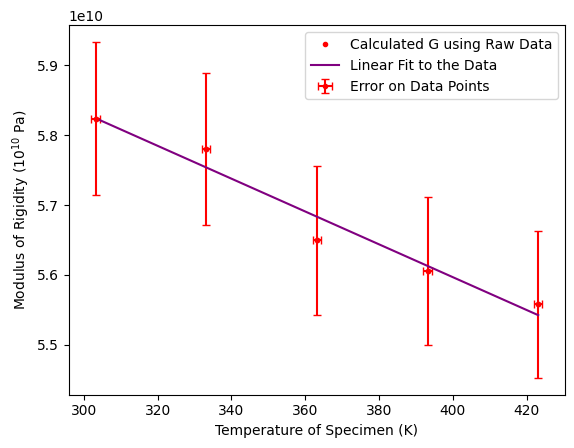

In [324]:
# plt.title('Theoretical Model of the Resonance from Data taken using ODR')
plt.xlabel('Temperature of Specimen (K)')
plt.ylabel('Modulus of Rigidity ($10^{10}$ Pa)')

plt.plot(temp, G, '.', label='Calculated G using Raw Data', color = 'r')
plt.errorbar(temp, G, xerr=sT, yerr=sG, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, G_fit, color = 'purple', label='Linear Fit to the Data')

plt.legend()
plt.savefig('GvsTAluminiRawData.png')
plt.show()

In [325]:
EstimateofSlope = (Q[3] - Q[2]) / (temp[3] - temp[2])

# Creating another ODR model to model the G trend

mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)

myodrQ = ODR(mydataQ, linear, beta0=[EstimateofSlope, 0])

myoutputQ = myodrQ.run()

myoutputQ.pprint()

temp_fit = np.linspace(min(temp), max(temp), 1000)
Q_fit = LinearApproximation(myoutputQ.beta, temp_fit)

Beta: [ 0.211368   -4.79027164]
Beta Std Error: [ 0.18362972 64.34167679]
Beta Covariance: [[ 1.80907238e-03 -6.31236168e-01]
 [-6.31236168e-01  2.22103159e+02]]
Residual Variance: 18.6393177995641
Inverse Condition #: 2.602015673872534e-05
Reason(s) for Halting:
  Sum of squares convergence


In [326]:
# Define the exponential model
def exponential_model(beta, x):
    a, b = beta  # 'beta' contains the parameters 'a' and 'b'
    return a * np.exp(b * x)

# Create the model object for ODR
Exponential = Model(exponential_model)

# Prepare the data (with errors for both temp and Q)
mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)  # temp: temperature, Q: internal friction, sT_array, sQ: uncertainties

# Set up ODR with the initial guess for parameters [a, b]
myodrQ = ODR(mydataQ, Exponential, beta0=[1, 0.001])  # beta0: initial guess

# Run the ODR regression
myoutputQ = myodrQ.run()

# Print the output
myoutputQ.pprint()

# Extract the fitted parameters and apply the model to your fit range
Q_fit2 = exponential_model(myoutputQ.beta, temp_fit)  # temp_fit: the temperature range for the fit

Beta: [2.16279389e+01 3.30503025e-03]
Beta Std Error: [1.85039140e+01 2.39076879e-03]
Beta Covariance: [[ 1.95122479e+01 -2.50940045e-03]
 [-2.50940045e-03  3.25728125e-07]]
Residual Variance: 17.547687762006564
Inverse Condition #: 0.011111799042944452
Reason(s) for Halting:
  Sum of squares convergence


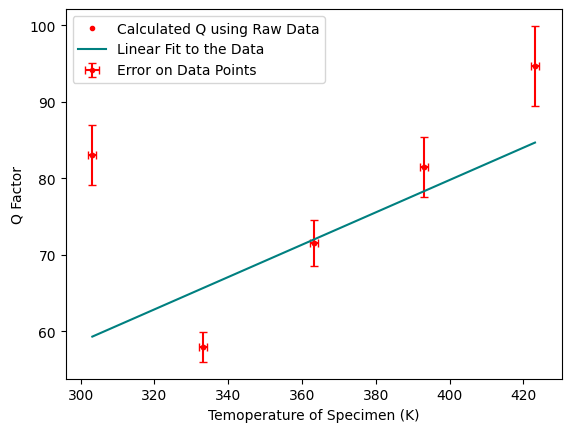

In [327]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temoperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.legend()
plt.savefig('QvsTAluminiRawDataLin.png')
plt.show()

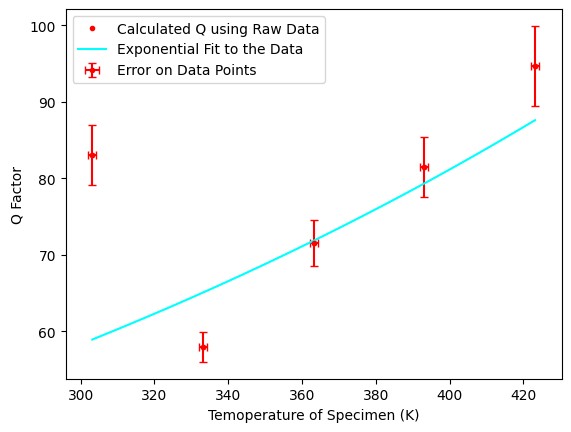

In [328]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temoperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTAluminiRawDataExp.png')
plt.show()

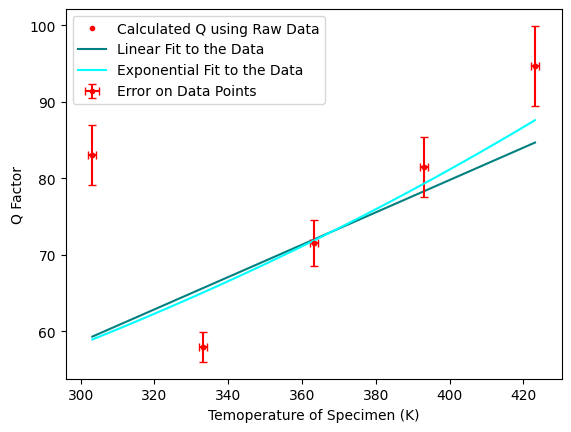

In [329]:
# Plotting the Internal Friction vs the Temperature
plt.xlabel('Temoperature of Specimen (K)')
plt.ylabel('Q Factor')
plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
plt.plot(temp_fit, Q_fit2, color = 'cyan', label='Exponential Fit to the Data')
plt.legend()
plt.savefig('QvsTAluminiRawDataBoth.png')
plt.show()

In [330]:
# Q = [57.9093867,  71.56400924, 81.47072127, 94.63925613]
# temp = [333.15, 363.15, 393.15, 423.15]

# EstimateofSlope = (Q[2] - Q[1]) / (temp[2] - temp[1])

# # Creating another ODR model to model the G trend

# mydataQ = RealData(temp, Q, sx=sT_array, sy=sQ)

# myodrQ = ODR(mydataQ, linear, beta0=[EstimateofSlope, 0])

# myoutputQ = myodrQ.run()

# myoutputQ.pprint()

# temp_fit = np.linspace(min(temp), max(temp), 1000)
# Q_fit = LinearApproximation(myoutputQ.beta, temp_fit)

In [331]:
# print(sT)
# sT = [np.float64(1.118033988749895), np.float64(1.118033988749895), np.float64(1.118033988749895), np.float64(1.118033988749895)]
# print(sQ)
# sQ = [1.9322546,  2.9837981,  3.88153032, 5.25971729]

In [332]:
# # Plotting the Internal Friction vs the Temperature
# plt.xlabel('Temoperature of Specimen (K)')
# plt.ylabel('Q Factor')
# plt.plot(temp, Q, '.', label='Calculated Q using Raw Data', color='r')
# plt.errorbar(temp, Q, xerr=sT, yerr=sQ, fmt='.', color='r', label='Error on Data Points', capsize=3)
# plt.plot(temp_fit, Q_fit, color = 'teal', label='Linear Fit to the Data')
# plt.legend()
# plt.savefig('QvsTAluminiRawDataLinNoOutlier.png')
# plt.show()